In [18]:
import MOBSTERm.model_mobster as model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy import stats

import torch
import seaborn as sns

import matplotlib.pyplot as plt

from MOBSTERm.plot_functions import *
from MOBSTERm.BoundedPareto import BoundedPareto
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
data = pd.read_csv("data/test_data.csv")
data

,mutation_id,chr,from,ref,alt,causes,classes,to,Sample.A.NV,Sample.B.NV,Sample.A.DP,Sample.B.DP,Sample.A.VAF,Sample.B.VAF,chr_pos
0,14_16008308_16008308_T_G,14,16008308,T,G,SBS5,passenger,16008308,5,0,77,87,0.064935,0.000000,16008308
1,14_16021016_16021016_C_A,14,16021016,C,A,SBS5,passenger,16021016,23,0,83,79,0.277108,0.000000,16021016
2,14_16038028_16038028_C_G,14,16038028,C,G,SBS5,passenger,16038028,0,33,79,75,0.000000,0.440000,16038028
3,14_16053575_16053575_G_A,14,16053575,G,A,SBS5,passenger,16053575,0,34,87,75,0.000000,0.453333,16053575
4,14_16072811_16072811_G_A,14,16072811,G,A,SBS1,passenger,16072811,12,0,95,63,0.126316,0.000000,16072811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16587,19_58551962_58551962_G_A,19,58551962,G,A,SBS1,pre-neoplastic,58551962,27,49,62,81,0.435484,0.604938,58551962
16588,19_58557357_58557357_C_T,19,58557357,C,T,SBS5,passenger,58557357,6,0,80,77,0.075000,0.000000,58557357
16589,19_58559817_58559817_A_G,19,58559817,A,G,SBS5,passenger,58559817,0,14,83,69,0.000000,0.202899,58559817
16590,19_58581905_58581905_C_T,19,58581905,C,T,SBS1,passenger,58581905,0,50,74,91,0.000000,0.549451,58581905


In [20]:
sets = ['Sample.A', 'Sample.B']

NV_list = []
DP_list = []

for s in sets:
    print(s)
    NV = torch.tensor(data[f'{s}.NV'].to_numpy())
    DP = torch.tensor(data[f'{s}.DP'].to_numpy())
    
    NV_list.append(NV.view(-1, 1))
    DP_list.append(DP.view(-1, 1))

NV = torch.cat(NV_list, dim=1)
DP = torch.cat(DP_list, dim=1)
purity = [1,1]
print(NV.shape, DP.shape)
K_list = [5,6,7,8,9]

Sample.A
Sample.B
torch.Size([16592, 2]) torch.Size([16592, 2])


In [21]:
mut_id = data['mutation_id'].tolist()

In [ ]:
seed_list = [40,41]
mb = model_mobster_mv.fit(NV = NV, DP = DP, mut_id=mut_id, num_iter=1500, K=K_list, seed_list=seed_list, lr=0.01, purity = purity)

RUN WITH K = 5 AND SEED = 40
Iteration 0: Loss = 1666433164.720292
Iteration 50: Loss = 1365879899.8411965
Iteration 100: Loss = 1324788062.7501473
Iteration 150: Loss = 1314051499.3720694
Iteration 200: Loss = 1310769097.9722316
Iteration 250: Loss = 1309329214.6714542
Iteration 300: Loss = 1308507124.7341075
Iteration 350: Loss = 1308046990.9466918
Inference lk:  -78811.91348515285
Final lk:  tensor(-407051.4062, grad_fn=<SumBackward0>)
n_params:  75
n:  tensor(16592)
lk:  tensor(-407051.4062, grad_fn=<SumBackward0>)
bic: 814831.5625 

RUN WITH K = 5 AND SEED = 41
Iteration 0: Loss = 1655982575.6867716
Iteration 50: Loss = 1367317854.9876907
Iteration 100: Loss = 1326407098.6002505
Iteration 150: Loss = 1315176693.5230968
Iteration 200: Loss = 1311294153.380246
Iteration 250: Loss = 1309714783.9818943
Iteration 300: Loss = 1308924301.0145068
Iteration 350: Loss = 1308395721.7556624
Iteration 400: Loss = 1307996725.9644678
Inference lk:  -78817.19606501384
Final lk:  tensor(-407078.37

/Users/elenarivaroli/Dropbox/phd/GitHub/MOBSTERm/MOBSTERm/plot_functions.py:557: UserWarning: The palette list has more values (27) than needed (7), which may not be intended.
  ax = sns.scatterplot(data=df, x=x_col, y=y_col, hue='Cluster', palette=palette, s=20, alpha = 0.7, edgecolor='none') # 'tab20'


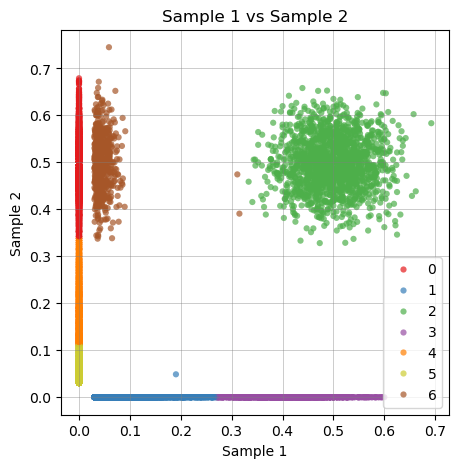

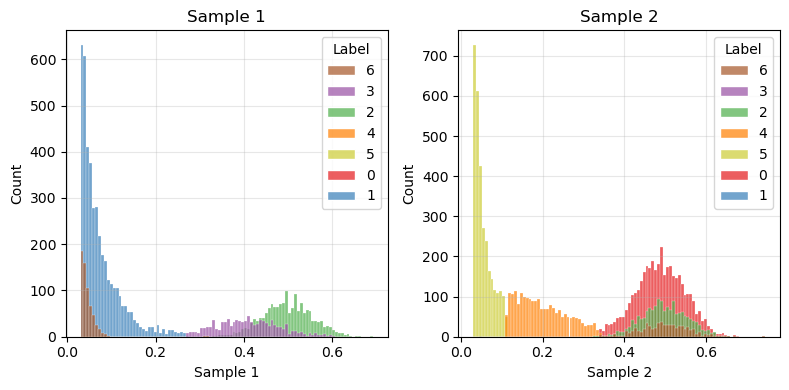

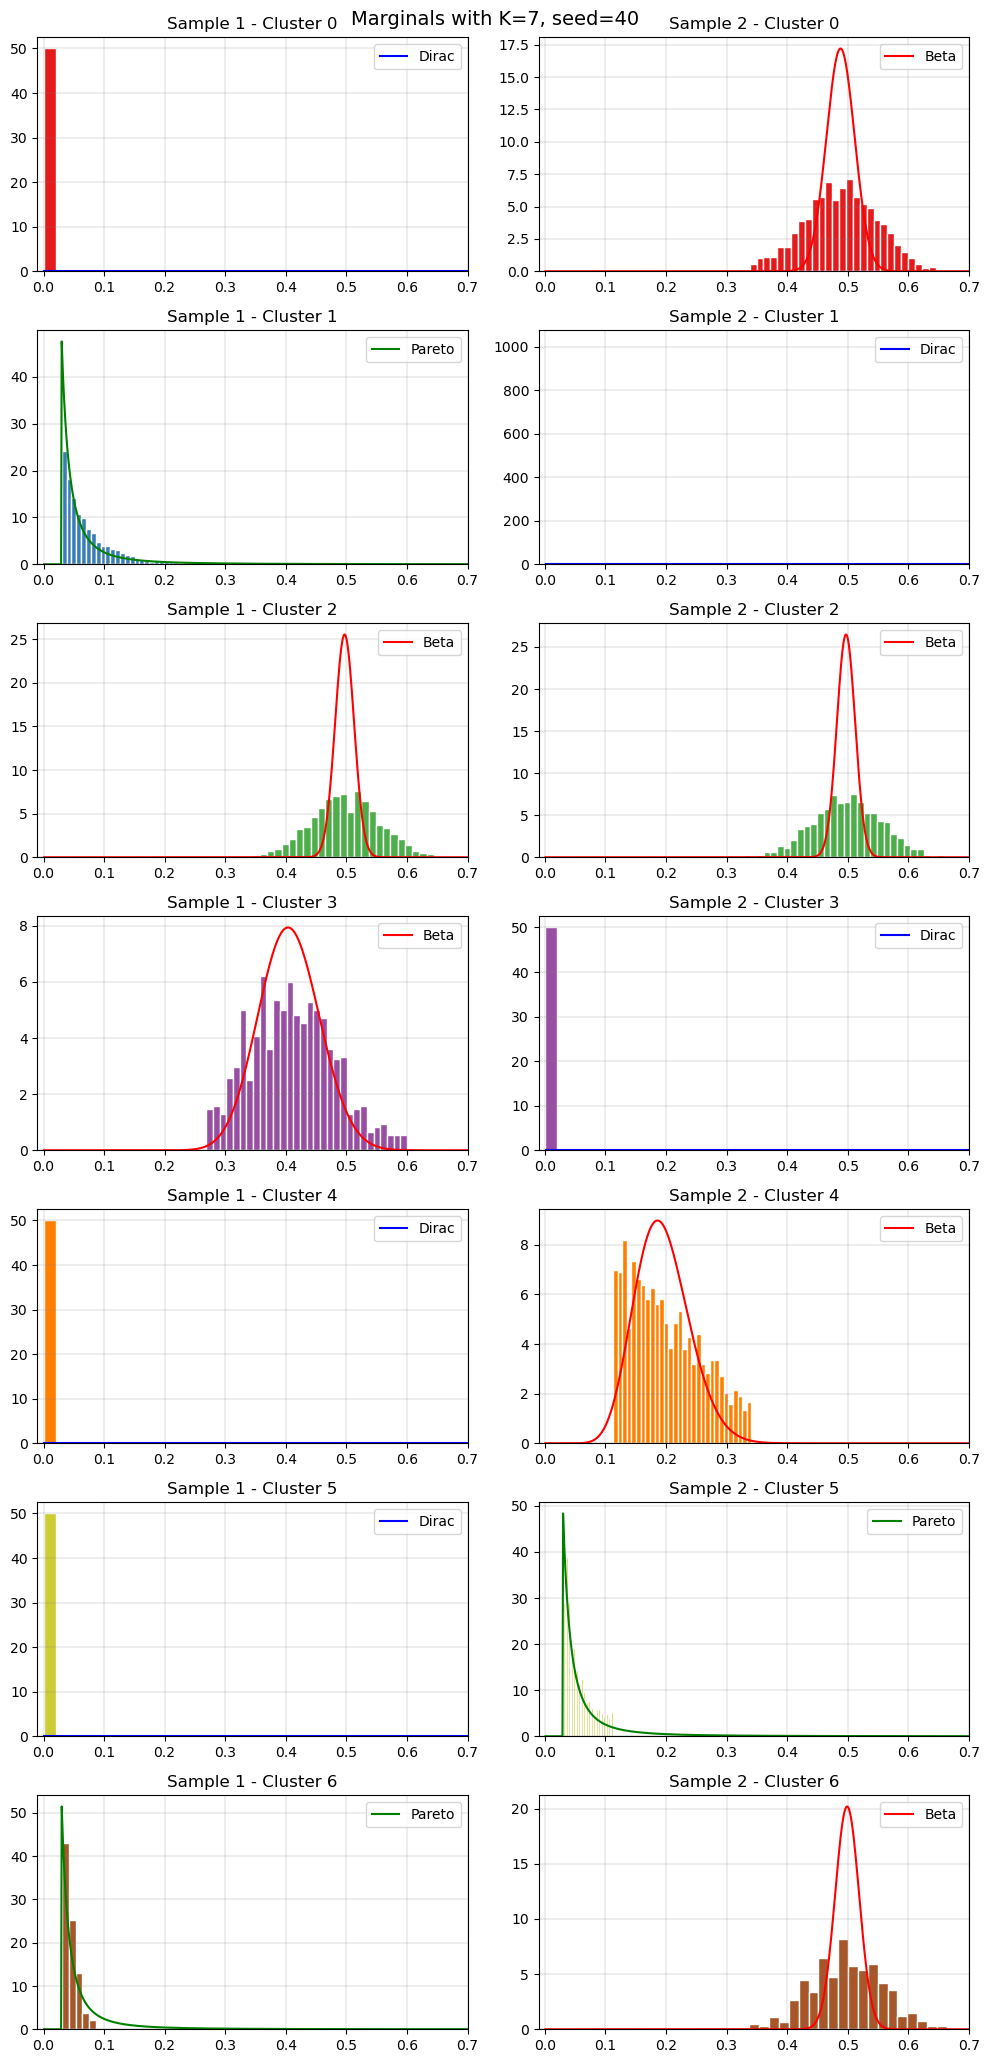

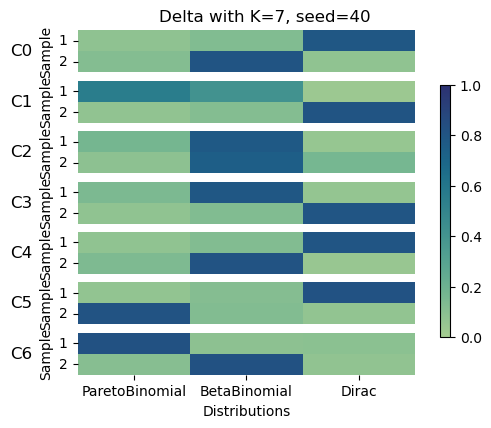

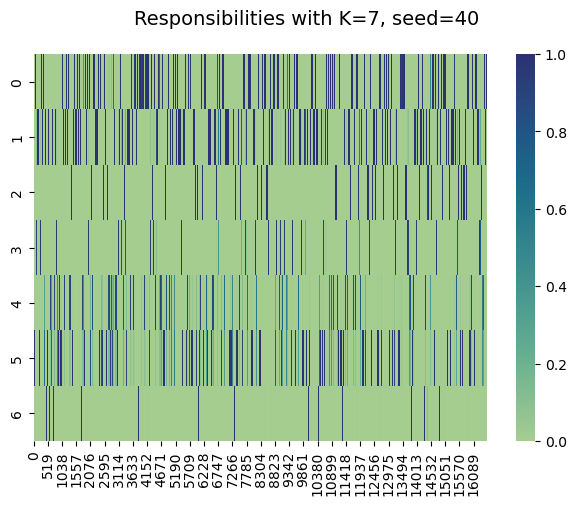

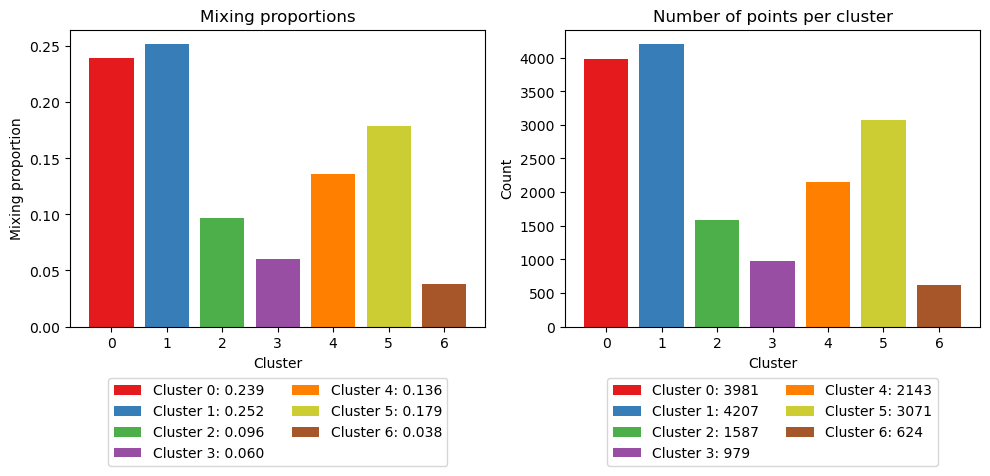

In [24]:
plot_scatter_inference(mb['best_fit'])
plot_marginals_inference(mb['best_fit'])
plot_marginals_single(mb['best_fit'])
plot_deltas(mb['best_fit'])
#plot_paretos(mb)
#plot_betas(mb)
plot_responsib(mb['best_fit'])
plot_mixing_proportions(mb['best_fit'])

### Test 1D

In [28]:
sets = ['Sample.A', 'Sample.B']

NV_list = []
DP_list = []

for s in sets:
    print(s)
    NV = torch.tensor(data[f'{s}.NV'].to_numpy())
    DP = torch.tensor(data[f'{s}.DP'].to_numpy())
    
    NV_list.append(NV.view(-1, 1))
    DP_list.append(DP.view(-1, 1))

NV = torch.cat(NV_list, dim=1)
DP = torch.cat(DP_list, dim=1)
purity = [1]
mut_id = data['mutation_id'].tolist()
print(NV.shape, DP.shape)

Sample.A
Sample.B
torch.Size([16592, 2]) torch.Size([16592, 2])


In [26]:
NV = NV[:,0]
DP = DP[:,0]
idx = np.where(NV!=0)[0]
NV = NV[idx]
DP = DP[idx]

In [29]:
seed_list = [40,41]
K_list = [2,3,4,5]
mb = model_mobster_mv.fit(NV, DP, num_iter=1500, mut_id=mut_id, K=K_list, seed=seed_list, lr=0.01, purity = purity)

RUN WITH K = 2 AND SEED = 40
Iteration 0: Loss = 2513641584.521845
Iteration 50: Loss = 1865773194.4715073
Iteration 100: Loss = 1675283943.9993007
Iteration 150: Loss = 1559934881.6063485
Iteration 200: Loss = 1494849590.6484048
Iteration 250: Loss = 1458892828.6291025
Iteration 300: Loss = 1438143050.522097
Iteration 350: Loss = 1425724593.870268
Iteration 400: Loss = 1417985396.0304575
Iteration 450: Loss = 1412955994.8265595
Inference lk:  -85027.91215740025
Final lk:  tensor(-297382.6562, grad_fn=<SumBackward0>)
n_params:  30
n:  tensor(16592)
lk:  tensor(-297382.6562, grad_fn=<SumBackward0>)
bic: 595056.8125 

RUN WITH K = 2 AND SEED = 41
Iteration 0: Loss = 2754044114.7055025
Iteration 50: Loss = 2151456213.441598
Iteration 100: Loss = 1944179269.0738459
Iteration 150: Loss = 1796346675.7825506
Iteration 200: Loss = 1665762432.9911592
Iteration 250: Loss = 1564132668.3266692
Iteration 300: Loss = 1501343799.3436377
Iteration 350: Loss = 1465966865.4116046
Iteration 400: Loss = 1

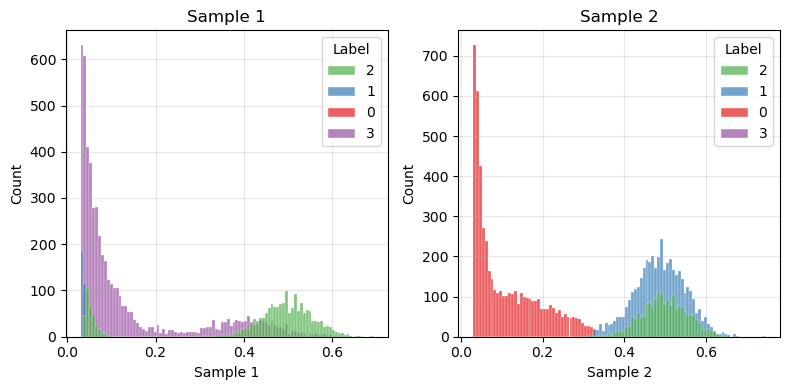

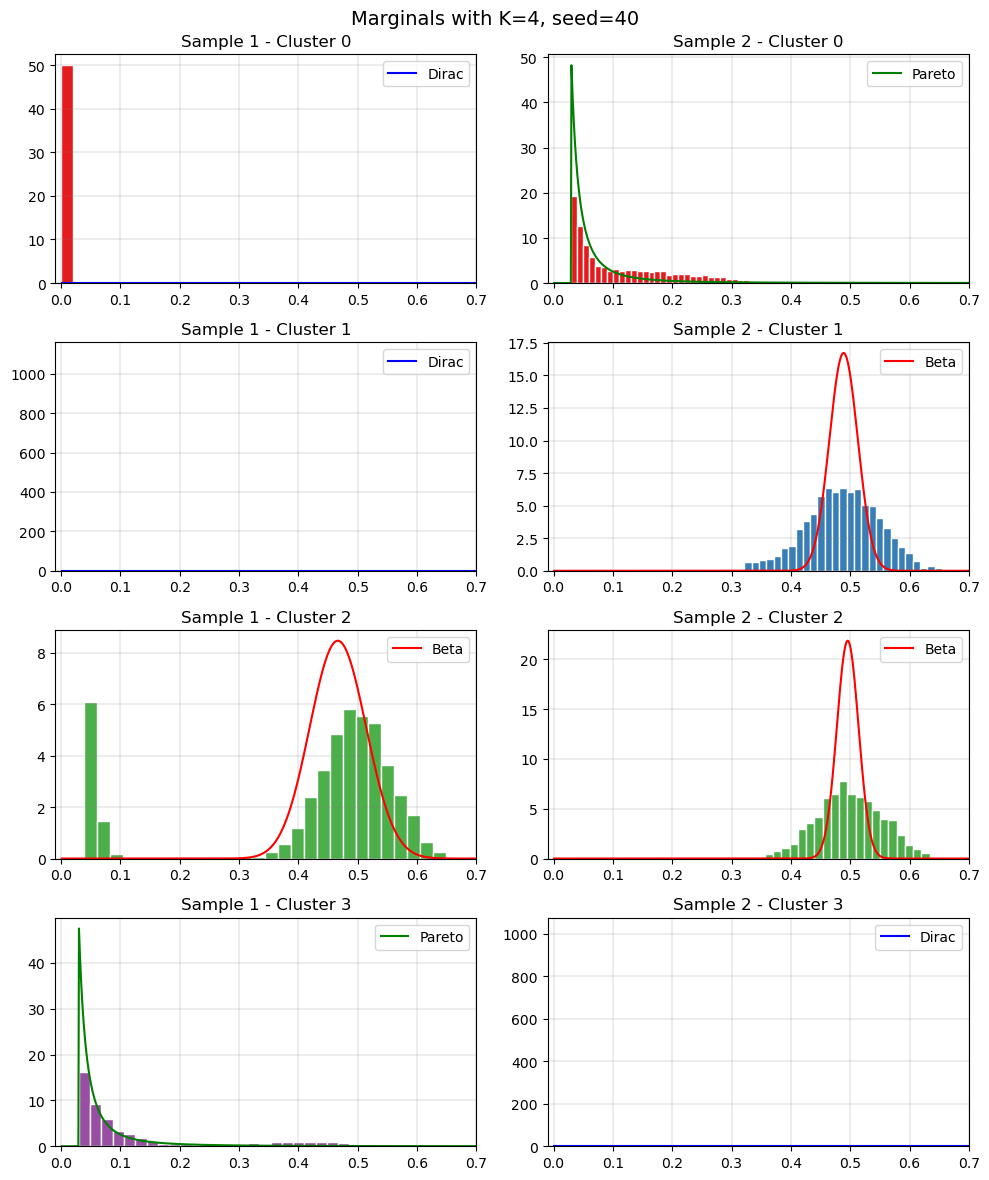

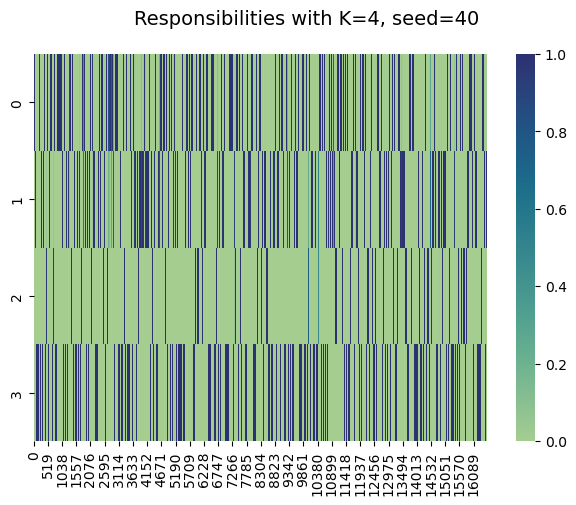

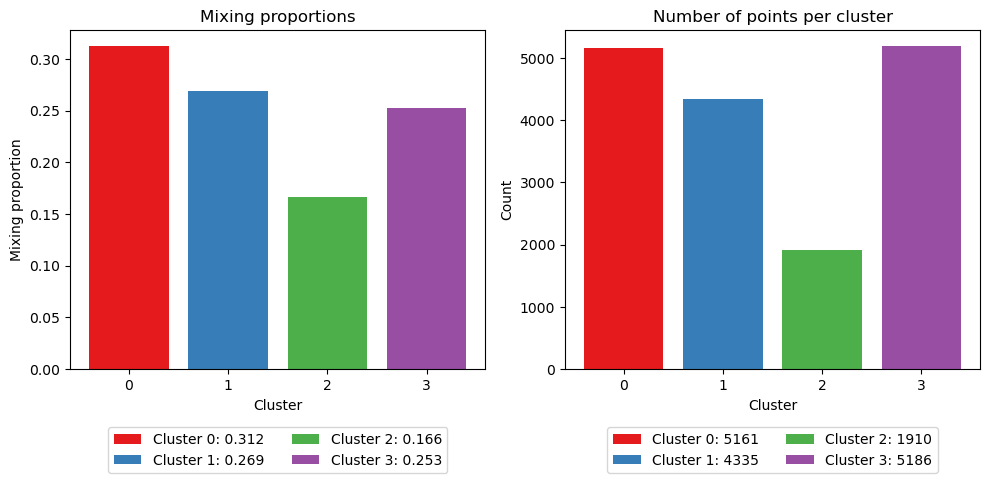

In [30]:
plot_marginals_inference(mb['best_fit'])
plot_marginals_single(mb['best_fit'])
plot_responsib(mb['best_fit'])
plot_mixing_proportions(mb['best_fit'])